In [ ]:
from google.colab import files, drive
import zipfile
import shutil
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, Conv2D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from collections import Counter
import random
from matplotlib.backends.backend_pdf import PdfPages
import json
import cv2

In [ ]:
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/ML_Tensorflow/phytoplankton_labeled.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

data_dir = '/content/dataset/labeled_20201020'

base_dir = '/content/dataset/groups'

Mounted at /content/drive


In [ ]:
max_samples = 225

# Function to augment and save images to balance the classes
def augment_class(src_dir, current_count, max_samples):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    files_to_augment = os.listdir(src_dir)
    num_to_augment = max_samples - current_count
    augmented_files = 0

    for file_name in files_to_augment:
        print(f"Num to augment: {num_to_augment}.")
        if augmented_files >= num_to_augment:
            break

        image_path = os.path.join(src_dir, file_name)
        image = cv2.imread(image_path)
        if image is None:
            continue

        image = np.expand_dims(image, axis=0)
        for x_batch in datagen.flow(image, batch_size=1):
            aug_image_path = os.path.join(src_dir, f"{file_name}_aug_{augmented_files}")
            cv2.imwrite(aug_image_path, x_batch[0][0])
            augmented_files += 1

            if augmented_files >= num_to_augment:
                break

def create_directory(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

sub_dirs = ['train', 'val', 'test']
groups = [f'group_{i}' for i in range(1, 6)]

for sub_dir in sub_dirs:
    for group in groups:
        create_directory(os.path.join(base_dir, sub_dir, group))

class_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for index, class_dir in enumerate(class_dirs):
    group_number = index // 10 + 1
    src_dir = os.path.join(data_dir, class_dir)

    current_files_count = len([f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))])
    # print(f"current files in {class_dir}: {current_files_count}")
    if current_files_count < max_samples:
        augment_class(src_dir, current_files_count, max_samples)

    # Get the list of files after augmentation
    all_files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    random.shuffle(all_files)

    # Split the files into train, validation, and test sets
    train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)

    # Copy files to their respective group directories
    for file_name in train_files[:max_samples]:
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(base_dir, 'train', f'group_{group_number}'))
    for file_name in val_files[:max_samples]:
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(base_dir, 'val', f'group_{group_number}'))
    for file_name in test_files[:max_samples]:
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(base_dir, 'test', f'group_{group_number}'))

print("Grouping and copying complete.")


Grouping and copying complete.


In [ ]:
num_classes = 5
batch_size = 32

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

def create_model(num_classes):
    # Load MobileNetV2 pre-trained on ImageNet data
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
    base_model.trainable = False  # Freeze the base model

    # Add custom layers on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'num_classes' units
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


def build_data_generators(train_dir, val_dir, test_dir, batch_size):

    # Rescale images to have pixel values in the range [0, 1]
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        # shear_range=0.3,
        # zoom_range=0.3,
        fill_mode='nearest'
        )


    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create data generators for training and validation
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Create data generator for testing
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Important for test set to not shuffle for evaluation
    )

    return train_generator, val_generator, test_generator

model = create_model(num_classes)
train_generator, val_generator, test_generator = build_data_generators(train_dir, val_dir, test_dir, batch_size)

Found 7359 images belonging to 5 classes.
Found 5126 images belonging to 5 classes.
Found 5087 images belonging to 5 classes.


Epoch 1/16
229/229 - 340s - loss: 0.3966 - accuracy: 0.8508 - val_loss: 0.7203 - val_accuracy: 0.7320 - 340s/epoch - 1s/step
Epoch 2/16
229/229 - 355s - loss: 0.3547 - accuracy: 0.8687 - val_loss: 0.5929 - val_accuracy: 0.7797 - 355s/epoch - 2s/step
Epoch 3/16
229/229 - 352s - loss: 0.3203 - accuracy: 0.8809 - val_loss: 0.5908 - val_accuracy: 0.7902 - 352s/epoch - 2s/step
Epoch 4/16
229/229 - 341s - loss: 0.2960 - accuracy: 0.8884 - val_loss: 0.5502 - val_accuracy: 0.8111 - 341s/epoch - 1s/step
Epoch 5/16
229/229 - 345s - loss: 0.2650 - accuracy: 0.9000 - val_loss: 0.5983 - val_accuracy: 0.7961 - 345s/epoch - 2s/step
Epoch 6/16
229/229 - 334s - loss: 0.2641 - accuracy: 0.8993 - val_loss: 0.5417 - val_accuracy: 0.8168 - 334s/epoch - 1s/step
Epoch 7/16
229/229 - 359s - loss: 0.2460 - accuracy: 0.9101 - val_loss: 0.5070 - val_accuracy: 0.8281 - 359s/epoch - 2s/step
Epoch 8/16
229/229 - 344s - loss: 0.2224 - accuracy: 0.9169 - val_loss: 0.5440 - val_accuracy: 0.8191 - 344s/epoch - 2s/step


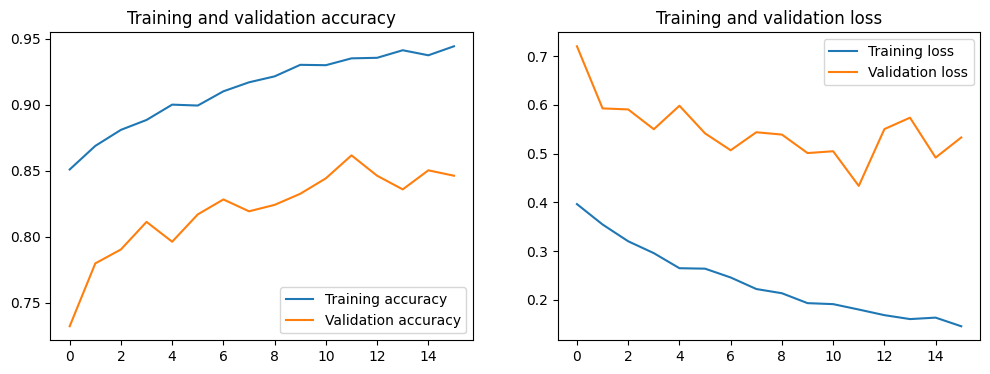

158/158 [==============================] - 105s 660ms/step - loss: 0.5243 - accuracy: 0.8434
Test accuracy: 84.34%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved the parent model to /content/drive/MyDrive/ML_Tensorflow/model_parent_17.h5


In [ ]:
 epochs = 16

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    verbose=2
)

# Convert the training history into a dictionary
history_dict = history.history

# Serialize the dictionary into JSON
history_json = json.dumps(history_dict, indent=4)

# Specify the directory to save the history
history_save_dir = f'/content/drive/MyDrive/ML_Tensorflow/training_history_parent_1.json'

# Write the JSON data to a file
with open(history_save_dir, 'w') as f:
    f.write(history_json)

print(f"Saved the training history to {history_save_dir}")

# Plot training history
plot_training_history(history)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

save_dir = '/content/drive/MyDrive/ML_Tensorflow/model_parent_17.h5'
model.save(save_dir)
print(f"Saved the parent model to {save_dir}")

In [ ]:
model_dirs = []

model_source_path = '/content/drive/MyDrive/ML_Tensorflow/'

model_dirs.append(model_source_path + 'model_parent_17.h5')

with PdfPages('parent_model_evaluation_report.pdf') as pdf:
    for model_dir in model_dirs:
        model = load_model(model_dir)

        # Ensure your test_generator is set correctly for the current model
        test_dir = f'/content/dataset/groups/test'

        test_generator.shuffle = False
        test_generator.reset()

        # Predict using the model
        predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

        # Convert predictions to class indices
        predicted_class_indices = np.argmax(predictions, axis=1)

        # Get true labels from the generator
        true_labels = test_generator.classes

        # Calculate accuracy
        accuracy = np.sum(predicted_class_indices == true_labels) / len(true_labels)
        print(f"Accuracy for model {model_dir}: {accuracy}")

        # Generate and plot the confusion matrix
        conf_matrix = confusion_matrix(true_labels, predicted_class_indices)

        plt.figure(figsize=(10, 10))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for model {model_dir}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        pdf.savefig()  # Save the current figure into the pdf
        plt.close()

        # Write classification report to PDF
        report = classification_report(true_labels, predicted_class_indices, target_names=list(test_generator.class_indices.keys()))
        pdf.attach_note(report)

        # Optional: Print classification report
        print(classification_report(true_labels, predicted_class_indices, target_names=list(test_generator.class_indices.keys())))


159/159 [==============================] - 103s 643ms/step
Accuracy for model /content/drive/MyDrive/ML_Tensorflow/model_parent_17.h5: 0.8439158639669746
              precision    recall  f1-score   support

     group_1       0.92      0.87      0.89       671
     group_2       0.91      0.81      0.85      1366
     group_3       0.61      0.93      0.73       716
     group_4       0.89      0.83      0.86       822
     group_5       0.91      0.84      0.87      1512

    accuracy                           0.84      5087
   macro avg       0.85      0.85      0.84      5087
weighted avg       0.87      0.84      0.85      5087

